In [ ]:
from google.colab import files
files.upload()

In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d jesucristo/gopro-data
! pip install einops

100% 8.88G/8.89G [05:00<00:00, 29.9MB/s]
100% 8.89G/8.89G [05:00<00:00, 31.8MB/s]
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install einops
import os
import cv2
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from einops import rearrange
from datetime import datetime

In [ ]:
import zipfile
zip_file_path = '/content/gopro-data.zip'
extracted_dir = '/content'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

In [ ]:
root_dir = "/content/train"
blurry_image_paths = []
sharp_image_paths = []
for folder in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder)
    for type_folder in os.listdir(folder_path):
        if type_folder == "sharp":
            for img in os.listdir(os.path.join(root_dir, folder, type_folder)):
                blurry_image_paths.append(os.path.join(root_dir, folder, "blur", img))
                sharp_image_paths.append(os.path.join(root_dir, folder, "sharp", img))

def are_paths_correct(file_paths):
    for path in file_paths:
        if not os.path.exists(path):
            return False
    return True

print("Are sharp paths correct?", are_paths_correct(sharp_image_paths))
print("Number of sharp paths:", len(sharp_image_paths))
print("Are blur paths correct?", are_paths_correct(blurry_image_paths))
print("Number of blur paths:", len(blurry_image_paths))

Are sharp paths correct? True
Number of sharp paths: 2103
Are blur paths correct? True
Number of blur paths: 2103


In [ ]:
class GoProDataset(Dataset):
    def __init__(self, root_dir, patch_size=None):
        super().__init__()

        self.root_dir = root_dir
        self.patch_size = patch_size

        self.blurry_image_paths = []
        self.sharp_image_paths = []

        for folder in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, folder)
            for type_folder in os.listdir(folder_path):
                if type_folder == "sharp":
                    for img in os.listdir(os.path.join(root_dir, folder, type_folder)):
                        self.blurry_image_paths.append(os.path.join(root_dir, folder, "blur", img))
                        self.sharp_image_paths.append(os.path.join(root_dir, folder, "sharp", img))

    def __len__(self):
        return len(self.blurry_image_paths)

    def extract_patches(self, image):
        unfold = nn.Unfold(kernel_size=self.patch_size, stride=self.patch_size)
        patches = unfold(image)
        num_patches = patches.shape[-1]
        patches = patches.view(3, self.patch_size, self.patch_size, num_patches)
        patches = patches.permute(3, 0, 1, 2)
        return patches

    def __getitem__(self, idx):
        blurry_image_path = self.blurry_image_paths[idx]
        sharp_image_path = self.sharp_image_paths[idx]

        blurry_image = Image.open(blurry_image_path)
        sharp_image = Image.open(sharp_image_path)

        blurry_image = transforms.ToTensor()(blurry_image)
        sharp_image = transforms.ToTensor()(sharp_image)

        if self.patch_size is not None:
            # Extract patches from the images
            blurry_image = self.extract_patches(blurry_image)
            sharp_image = self.extract_patches(sharp_image)

        return blurry_image, sharp_image

    def original_shape(self, idx):
        blurry_image_path = self.blurry_image_paths[idx]
        sharp_image_path = self.sharp_image_paths[idx]

        blurry_image = Image.open(blurry_image_path)
        sharp_image = Image.open(sharp_image_path)

        blurry_image = transforms.ToTensor()(blurry_image)
        sharp_image = transforms.ToTensor()(sharp_image)

        return blurry_image.shape, sharp_image.shape

In [ ]:
dataset = GoProDataset(root_dir, 512)
dataloader = DataLoader(dataset, shuffle=True, num_workers=2)

In [ ]:
print("Original Shape => ", dataset.original_shape(1)[0])
print("Shape after extract Patches => ", dataset[1][0].shape)

Original Shape =>  torch.Size([3, 720, 1280])
Shape after extract Patches =>  torch.Size([2, 3, 512, 512])


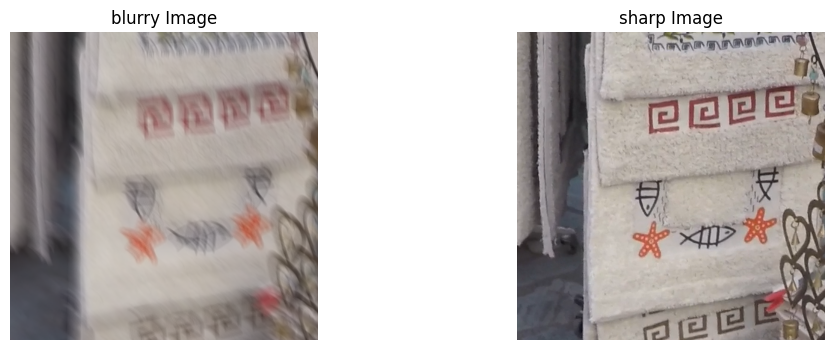

In [ ]:
import matplotlib.pyplot as plt
sample = 0
noisy_image = dataset[0][0][sample].permute(1, 2, 0).cpu().numpy()
ground_truth_image = dataset[0][1][sample].permute(1, 2, 0).cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].imshow(noisy_image)
axes[0].set_title("blurry Image")
axes[0].axis('off')

axes[1].imshow(ground_truth_image)
axes[1].set_title("sharp Image")
axes[1].axis('off')

plt.show()

# Layer Normalization

In [ ]:
class LayerNormFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, weight, bias, eps):
        ctx.eps = eps
        N, C, H, W = x.size()
        mu = x.mean(1, keepdim=True)
        var = (x - mu).pow(2).mean(1, keepdim=True)
        y = (x - mu) / (var + eps).sqrt()
        ctx.save_for_backward(y, var, weight)
        y = weight.view(1, C, 1, 1) * y + bias.view(1, C, 1, 1)
        return y

    @staticmethod
    def backward(ctx, grad_output):
        eps = ctx.eps

        N, C, H, W = grad_output.size()
        y, var, weight = ctx.saved_tensors
        g = grad_output * weight.view(1, C, 1, 1)
        mean_g = g.mean(dim=1, keepdim=True)

        mean_gy = (g * y).mean(dim=1, keepdim=True)
        gx = 1. / torch.sqrt(var + eps) * (g - y * mean_gy - mean_g)
        return gx, (grad_output * y).sum(dim=3).sum(dim=2).sum(dim=0), grad_output.sum(dim=3).sum(dim=2).sum(
            dim=0), None

class LayerNorm2d(nn.Module):

    def __init__(self, channels, eps=1e-6):
        super(LayerNorm2d, self).__init__()
        self.register_parameter('weight', nn.Parameter(torch.ones(channels)))
        self.register_parameter('bias', nn.Parameter(torch.zeros(channels)))
        self.eps = eps

    def forward(self, x):
        return LayerNormFunction.apply(x, self.weight, self.bias, self.eps)

# Multi Dconv Head Transposed Attention

In [ ]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads, bias):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        self.temperature = nn.Parameter(torch.ones(num_heads, 1, 1))

        self.qkv = nn.Conv2d(dim, dim*3, kernel_size=1, bias=bias)
        self.qkv_dwconv = nn.Conv2d(dim*3, dim*3, kernel_size=3, stride=1, padding=1, groups=dim*3, bias=bias)
        self.project_out = nn.Conv2d(dim, dim, kernel_size=1, bias=bias)

    def forward(self, x):
        b,c,h,w = x.shape

        qkv = self.qkv_dwconv(self.qkv(x))
        q,k,v = qkv.chunk(3, dim=1)

        q = rearrange(q, 'b (head c) h w -> b head c (h w)', head=self.num_heads)
        k = rearrange(k, 'b (head c) h w -> b head c (h w)', head=self.num_heads)
        v = rearrange(v, 'b (head c) h w -> b head c (h w)', head=self.num_heads)

        q = torch.nn.functional.normalize(q, dim=-1)
        k = torch.nn.functional.normalize(k, dim=-1)

        attn = (q @ k.transpose(-2, -1)) * self.temperature
        attn = attn.softmax(dim=-1)

        out = (attn @ v)

        out = rearrange(out, 'b head c (h w) -> b (head c) h w', head=self.num_heads, h=h, w=w)

        out = self.project_out(out)
        return out

# Simple Gate

In [ ]:
class SimpleGate(nn.Module):
    def forward(self, x):
        x1, x2 = x.chunk(2, dim=1)
        return x1 * x2

# NAF Block

In [ ]:
class NAFBlock(nn.Module):
    def __init__(self, c, DW_Expand=2, FFN_Expand=2, dropout_rate=0.):
        super().__init__()
        dw_channel = c * DW_Expand
        self.conv1 = nn.Conv2d(in_channels=c, out_channels=dw_channel, kernel_size=1, padding=0, stride=1, groups=1, bias=True)
        self.conv2 = nn.Conv2d(in_channels=dw_channel, out_channels=dw_channel, kernel_size=3, padding=1, stride=1, groups=dw_channel, bias=True)
        self.conv3 = nn.Conv2d(in_channels=dw_channel // 2, out_channels=c, kernel_size=1, padding=0, stride=1, groups=1, bias=True)

        self.mdta = Attention(c, 8, True)

        self.sg = SimpleGate()

        ffn_channel = FFN_Expand * c

        self.conv4 = nn.Conv2d(in_channels=c, out_channels=ffn_channel, kernel_size=1, padding=0, stride=1, groups=1, bias=True)
        self.conv5 = nn.Conv2d(in_channels=ffn_channel // 2, out_channels=c, kernel_size=1, padding=0, stride=1, groups=1, bias=True)

        self.norm1 = LayerNorm2d(c)
        self.norm2 = LayerNorm2d(c)

        self.dropout1 = nn.Dropout(dropout_rate) if dropout_rate > 0. else nn.Identity()
        self.dropout2 = nn.Dropout(dropout_rate) if dropout_rate > 0. else nn.Identity()

        self.beta = nn.Parameter(torch.zeros((1, c, 1, 1)), requires_grad=True)
        self.gamma = nn.Parameter(torch.zeros((1, c, 1, 1)), requires_grad=True)

    def forward(self, input):
        x = input

        x = self.norm1(x)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.sg(x)
        x = x * self.mdta(x)
        x = self.conv3(x)

        x = self.dropout1(x)

        y = input + x * self.beta

        x = self.conv4(self.norm2(y))
        x = self.sg(x)
        x = self.conv5(x)

        x = self.dropout2(x)

        return y + x * self.gamma

# U-Net Architecture

In [ ]:
class NAFNet(nn.Module):
    def __init__(self, img_channel=3, width=16, middle_blk_num=1, enc_blk_nums=[], dec_blk_nums=[]):
        super().__init__()

        self.intro = nn.Conv2d(in_channels=img_channel, out_channels=width, kernel_size=3, padding=1, stride=1, groups=1,
                              bias=True)
        self.ending = nn.Conv2d(in_channels=width, out_channels=img_channel, kernel_size=3, padding=1, stride=1, groups=1,
                              bias=True)

        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()
        self.middle_blks = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()

        chan = width
        for num in enc_blk_nums:
            self.encoders.append(
                nn.Sequential(
                    *[NAFBlock(chan) for _ in range(num)]
                )
            )
            self.downs.append(
                nn.Conv2d(chan, 2*chan, 2, 2)
            )
            chan = chan * 2

        self.middle_blks = \
            nn.Sequential(
                *[NAFBlock(chan) for _ in range(middle_blk_num)]
            )

        for num in dec_blk_nums:
            self.ups.append(
                nn.Sequential(
                    nn.Conv2d(chan, chan * 2, 1, bias=False),
                    nn.PixelShuffle(2)
                )
            )
            chan = chan // 2
            self.decoders.append(
                nn.Sequential(
                    *[NAFBlock(chan) for _ in range(num)]
                )
            )

        self.padder_size = 2 ** len(self.encoders)

    def forward(self, inp):
        B, C, H, W = inp.shape
        inp = self.check_image_size(inp)

        x = self.intro(inp)

        encs = []

        for encoder, down in zip(self.encoders, self.downs):
            x = encoder(x)
            encs.append(x)
            x = down(x)

        x = self.middle_blks(x)

        for decoder, up, enc_skip in zip(self.decoders, self.ups, encs[::-1]):
            x = up(x)
            x = x + enc_skip
            x = decoder(x)

        x = self.ending(x)
        x = x + inp

        return x[:, :, :H, :W]

    def check_image_size(self, x):
        _, _, h, w = x.size()
        mod_pad_h = (self.padder_size - h % self.padder_size) % self.padder_size
        mod_pad_w = (self.padder_size - w % self.padder_size) % self.padder_size
        x = F.pad(x, (0, mod_pad_w, 0, mod_pad_h))
        return x

In [ ]:
device = torch.device("cuda")

In [ ]:
img_channel = 3
width = 32

enc_blks = [1, 1, 1, 28]
middle_blk_num = 1
dec_blks = [1, 1, 1, 1]

model = NAFNet(img_channel=img_channel, width=width, middle_blk_num=middle_blk_num,
               enc_blk_nums=enc_blks, dec_blk_nums=dec_blks).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

In [ ]:
# num_epochs = 2
# with open("/content/drive/MyDrive/Training_model/training_progress_GoPro_afterchanginglearningrate.txt", "w") as file:
#     for epoch in range(num_epochs):
#         i = 0
#         batch_loss = []
#         for batch_no, (noisy_images, gt_images) in enumerate(dataloader):
#             patches_loss = []
#             for patch_index in range(noisy_images[0].size(0)):
#                 noisy_image = noisy_images[:, patch_index].to(device)
#                 gt_image = gt_images[:, patch_index].to(device)
#                 optimizer.zero_grad()
#                 outputs = model(noisy_image)
#                 loss = criterion(outputs, gt_image)
#                 loss.backward()
#                 optimizer.step()
#                 patches_loss.append(loss.item())
#                 progress_str = f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_no+1}/{len(dataloader)}], Patch [{patch_index+1}/{noisy_images[0].size(0)}], Loss: {loss.item()}"
#                 print(progress_str)
#                 file.write(progress_str + "\n")
#             batch_loss.append(sum(patches_loss) / len(patches_loss))
#             i += 1
#         if i % 500 == 0 and i != 0:
#             torch.save({
#                         'epoch': epoch,
#                         'model_state_dict': model.state_dict(),
#                         'optimizer_state_dict': optimizer.state_dict(),
#                     }, f"/content/drive/MyDrive/Training_model/nafnet_GoPro_epoch{epoch+1}_afterlrchanging.pth")
#         progress_str = f"Epoch [{epoch+1}/{num_epochs}], Epoch Loss: {sum(batch_loss) / len(batch_loss)}"
#         print(progress_str)
#         file.write(progress_str + "\n")
# file.close()

In [ ]:
# torch.save({
#     'epoch': epoch,
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
# }, f"/content/drive/MyDrive/Training_model/nafnet_GoPro_epoch{epoch+1}_afterlrchanging.pth")

In [ ]:
def add_to_excelsheet( epoch_number, epoch_loss):
    excel_file_path = '/content/drive/MyDrive/Training_model/TrainingProgress/training_results_GoPro_deblur.xlsx'
    Epoch_number = epoch_number
    Epoch_loss = epoch_loss
    learning_rate = 0.0001


    data = {'Epoch': [epoch_number], 'Loss': [epoch_loss], 'Learning Rate': [learning_rate]}
    df = pd.DataFrame(data)


    try:
        existing_df = pd.read_excel(excel_file_path)
        df = pd.concat([existing_df, df], ignore_index=True)
    except FileNotFoundError:
        pass


    with pd.ExcelWriter(excel_file_path, engine='openpyxl', mode='w') as writer:
        writer.book.sheets = dict((ws.title, ws) for ws in writer.book.worksheets)
        df.to_excel(writer, sheet_name='Sheet1', index=False)


In [ ]:
folder = "/content/drive/MyDrive/Training_model"
checkpoint_path = f"{folder}/GoPro_epoch_37.pth"
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
epoch = int(checkpoint_path.split("/")[-1].split("_")[-1][:-4])
print(epoch)
i = 0
num_epochs = epoch + 2
with open(f"{folder}/TrainingProgress/training_progress_GoPro_epoch_{epoch+1}.txt", "w") as file:
    for epoch in range(epoch + 1, num_epochs):
        i = 0
        batch_loss = []
        for batch_no, (noisy_images, gt_images) in enumerate(dataloader):
            patches_loss = []
            for patch_index in range(noisy_images[0].size(0)):
                noisy_image = noisy_images[:, patch_index].to(device)
                gt_image = gt_images[:, patch_index].to(device)
                optimizer.zero_grad()
                outputs = model(noisy_image)
                loss = criterion(outputs, gt_image)
                loss.backward()
                optimizer.step()
                patches_loss.append(loss.item())
                progress_str = f"Epoch [{epoch}], Step [{batch_no+1}/{len(dataloader)}], Patch [{patch_index+1}/{noisy_images[0].size(0)}], Loss: {loss.item()}"
                print(progress_str)
                file.write(progress_str + "\n")
            batch_loss.append(sum(patches_loss) / len(patches_loss))
            i += 1
            if i % 200 == 0 and i != 0:
                torch.save({
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                    }, f"{folder}/GoPro_epoch_{epoch}.pth")
                progress_str = f"Epoch [{epoch}], Epoch Loss: {sum(batch_loss) / len(batch_loss)}"
                print(progress_str)
                file.write(progress_str + "\n")
        torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, f"{folder}/GoPro_epoch_{epoch}.pth")
        Epoch_loss = sum(batch_loss) / len(batch_loss)
        progress_str = f"Epoch [{epoch}], Epoch Loss: {Epoch_loss}"
        print(progress_str)
        add_to_excelsheet(epoch, Epoch_loss)
        file.write(progress_str + "\n")
file.close()

37
Epoch [38], Step [1/2103], Patch [1/2], Loss: 0.003921015653759241
Epoch [38], Step [1/2103], Patch [2/2], Loss: 0.0014982137363404036
Epoch [38], Step [2/2103], Patch [1/2], Loss: 0.00019460381008684635
Epoch [38], Step [2/2103], Patch [2/2], Loss: 0.0003989535616710782
Epoch [38], Step [3/2103], Patch [1/2], Loss: 0.002073778538033366
Epoch [38], Step [3/2103], Patch [2/2], Loss: 0.001975516090169549
Epoch [38], Step [4/2103], Patch [1/2], Loss: 0.0002670126559678465
Epoch [38], Step [4/2103], Patch [2/2], Loss: 0.0004171338805463165
Epoch [38], Step [5/2103], Patch [1/2], Loss: 0.0005128745688125491
Epoch [38], Step [5/2103], Patch [2/2], Loss: 0.0007592407055199146
Epoch [38], Step [6/2103], Patch [1/2], Loss: 0.00022366660414263606
Epoch [38], Step [6/2103], Patch [2/2], Loss: 0.0003649769932962954
Epoch [38], Step [7/2103], Patch [1/2], Loss: 0.000461455259937793
Epoch [38], Step [7/2103], Patch [2/2], Loss: 0.0005036402144469321
Epoch [38], Step [8/2103], Patch [1/2], Loss: 0

In [ ]:
# add_to_excelsheet(epoch, Epoch_loss)

In [ ]:
test = GoProDataset("/content/test", 512)
test[0][0][0].shape

torch.Size([3, 512, 512])

In [ ]:
test_model = NAFNet(img_channel=img_channel, width=width, middle_blk_num=middle_blk_num,
               enc_blk_nums=enc_blks, dec_blk_nums=dec_blks).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

checkpoint_path = "/content/drive/MyDrive/Training_model/GoPro_epoch_37.pth"

checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

test_model.load_state_dict(checkpoint['model_state_dict'])

optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

test_model.eval()
img = 385
test_image = test[img][0][1].to(device)
with torch.no_grad():
      output_chunk = test_model(torch.unsqueeze(test_image, 0))

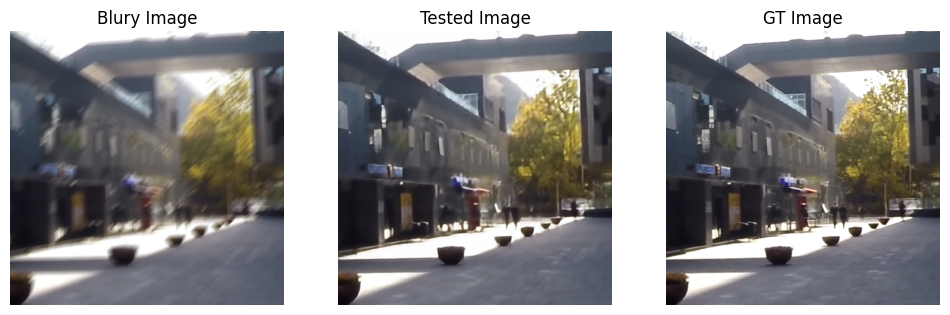

In [ ]:
import matplotlib.pyplot as plt
image_np1 = test_image.permute(1, 2, 0).cpu().numpy()
image_np2 = output_chunk[0].permute(1, 2, 0).cpu().numpy()
image_np3 = test[img][1][1].permute(1, 2, 0).cpu().numpy()

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(image_np1)
axes[0].set_title("Blury Image")
axes[0].axis('off')

axes[1].imshow(image_np2)
axes[1].set_title("Tested Image")
axes[1].axis('off')

axes[2].imshow(image_np3)
axes[2].set_title("GT Image")
axes[2].axis('off')
plt.savefig(f'/content/drive/MyDrive/Training_model/Test Progress/blurred_{img}_epoch30.png')
plt.show()

In [ ]:
test_model = NAFNet(img_channel=img_channel, width=width, middle_blk_num=middle_blk_num,
               enc_blk_nums=enc_blks, dec_blk_nums=dec_blks).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

checkpoint_path = "/content/drive/MyDrive/Training_model/GoPro_epoch_30.pth"

checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

test_model.load_state_dict(checkpoint['model_state_dict'])

optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

test_model.eval()
path = "/content/drive/MyDrive/Training_model/Test Progress/noisy_vegetable_tested.png"
test_image = Image.open(path)
test_image = transforms.ToTensor()(test_image).to(device)
test_image = test_image[:3, :, :]
with torch.no_grad():
      output_chunk = test_model(torch.unsqueeze(test_image, 0))

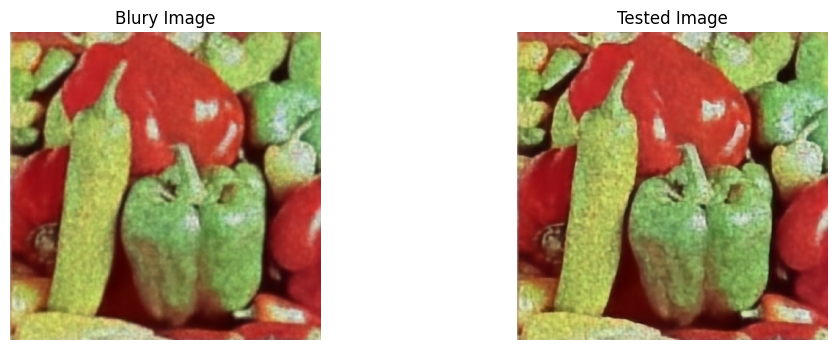

In [ ]:
import matplotlib.pyplot as plt
image_np1 = test_image.permute(1, 2, 0).cpu().numpy()
image_np2 = output_chunk[0].permute(1, 2, 0).cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].imshow(image_np1)
axes[0].set_title("Blury Image")
axes[0].axis('off')

axes[1].imshow(image_np2)
axes[1].set_title("Tested Image")
axes[1].axis('off')
folder = "/content/drive/MyDrive/Training_model/Test Progress"
# plt.savefig(f'{folder}/Blurred_vegetables_epoch30.png')
plt.show()

In [ ]:
# model.eval()
# from PIL import Image
# from torchvision import transforms

# image_path = "/kaggle/input/smartphone-image-denoising-dataset/SIDD_Small_sRGB_Only/Data/0001_001_S6_00100_00060_3200_L/NOISY_SRGB_010.PNG"
# image = Image.open(image_path)
# transform = transforms.Compose([
#     transforms.Resize((512, 512)),  # Resize to match the input size of your model
#     transforms.ToTensor()
# ])
# input_tensor = transform(image).unsqueeze(0)
# input_tensor = input_tensor.to(device)
# with torch.no_grad():
#     output = model(input_tensor)

# trans = transforms.Resize((3000, 5328))
# out_img = trans(output)
# print(out_img.shape)

In [ ]:
# Modified_model_state = "/kaggle/working/NAFNet_state_dict.pth"
# torch.save(model.state_dict(), Modified_model_state)

In [ ]:
# out_img = out_img.squeeze().detach().cpu()
# to_pil_image = transforms.ToPILImage()
# image = to_pil_image(out_img[0])

# # Save the image to a file (optional)
# image.save("/kaggle/working/mdta.png")

# # Display the image (optional)
# image.show()

In [ ]:
# noisy_image = Image.open(noisy_image_path)